# Determina√ß√£o de par√¢metros de exoplanetas por ajuste do tr√¢nsito pelo algoritmo MCMC

_Por meio da an√°lise da curva de luz de estrelas com tr√¢nsitos de exoplanetas e realizando um ajuste dos dados pelo modelo ECLIPSE utilizando o algoritmo MCMC (Markov Chain Monte Carlo) presente neste c√≥digo, √© poss√≠vel descobrir com maior precis√£o os par√¢metros reais do exoplaneta e sua √≥rbita. O programa foi otimizado para que seu tempo de execu√ß√£o fosse reduzido drasticamente._

In [1]:
from Adjust.Model import Modelo
from Adjust.Treatment import Tratamento
from Adjust.Adjust import Ajuste, AjusteManchado, AjusteCME
from Misc.Verify import converte, calculaLat
from Star.Estrela import Estrela
from Planet.Eclipse import Eclipse
from Planet.Planeta import Planeta
import numpy
import matplotlib.pyplot as plt
import corner

In [2]:
def plotLegendAdjust(plot, mission): 
    # Adicionando t√≠tulo e legendas dos eixos
    plot.title(f'Curva de luz extra√≠da do Telesc√≥pio { mission } x Curva de luz ajustada')
    plot.xlabel('Eixo X (Tempo)')
    plot.ylabel('Eixo Y (Brilho da estrela)')

    # Exibindo a legenda
    plot.legend()
    plot.show()

def plotLegendModel(ax, mission): 
 # Adicionando t√≠tulo e legendas dos eixos
    ax.set_title(f'Curva de luz extra√≠da do Telesc√≥pio { mission }  x Curva de luz modelo')
    ax.set_xlabel('Eixo X (Tempo)')
    ax.set_ylabel('Eixo Y (Brilho da estrela)')

    # Exibindo a legenda
    ax.legend()
    plt.show()

# Entrada Estrela e Eclipse

_A Estrela e o Eclipse ser√£o criados atrav√©s de classes auxiliares presentes nos arquivos ```eclipse.py``` e ```estrela.py```. A classe Estrela constr√≥i a matriz que representa a estrela, enquanto a classe Eclipse calcula a curva de luz daquela estrela dado par√¢metros planet√°rios imputados. Cada planeta tamb√©m pode conter uma lua em sua √≥rbita, dessa forma, cada eclipse pode possuir uma ou mais luas, atrav√©s da classe Moon. 
Os par√¢metros de cria√ß√£o da estrela e eclipse, juntamente com a(s) lua(s) est√£o presentes no bloco abaixo._

In [56]:
# -------------- Par√¢metros de entrada --------------
# --------------------- Estrela ---------------------
mission = "TESS"
star_name = 'HD189733A'
cadence = 'short'
raio = 373. #default (pixel)
rsun = 0.805 # raio da estrela em Rsun
intensidadeMaxima = 240 #default
tamanhoMatriz = 856 #default 
u1 = 0.377
u2 = 0.024
star_temp = 5560.0 #em Kelvin


# --------------------- Planeta HD189733-A ---------------------
raio_plan_Jup = 1.138
semi_eixo_UA = 0.031
angulo_inclinacao = 85.51 #em graus
periodo = 2.219 # day
mass_planeta = 1.138 #em relacao ao R de jupiter
lua = False 
ecc = 0
anomalia = 0

#etapa de convers√£o
#raioStar, raioPlanetaRstar , semiEixoRaioStar = converte(rsun, raio_plan_Jup, semi_eixo_UA)

In [214]:
# results = [0.5100347077942855, 0.10678029347412264, 0.046515795725497404, 89.71422330260803, 1.154298061365153]
results = [5.06355057e-01, 0.04378509e-01, 2.80005826e-02, 8.38863661e+01, 1.28862784e+00]
# results = [5.06355057e-01, 1.14378509e-01, 2.80005826e-02, 8.38863661e+01, 1.29862784e+00]
u1 = results[0]
u2 = results[1]
semi_eixo_UA = results[2]
angulo_inclinacao = results[3]
raio_plan_Jup = results[4]

### Constru√ß√£o da Estrela e do Eclipse
_Ap√≥s a constru√ß√£o da matriz estrela e do eclipse calculado, temos a resultante da curva de luz representada graficamente abaixo._

0.12469124794006348


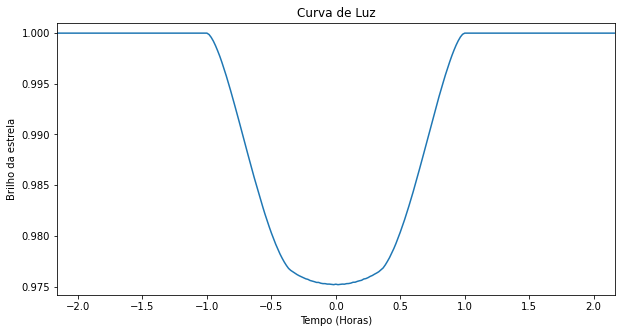

In [215]:
estrela_ = Estrela(raio, rsun, intensidadeMaxima, u1, u2, tamanhoMatriz)

Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()

planeta_ = Planeta(semi_eixo_UA, raio_plan_Jup, periodo, angulo_inclinacao, ecc, anomalia, estrela_.getRaioSun(), mass_planeta)

eclipse = Eclipse(Nx, Ny, raioEstrelaPixel, estrela_, planeta_)
estrela_.setStarName(star_name)
estrela_.setCadence(cadence)
eclipse.setTempoHoras(1.)

# criarEclipse(self, cme, anim=True, plot=True):
eclipse.criarEclipse(anim=False)
lc0 = numpy.array(eclipse.getCurvaLuz()) 
ts0 = numpy.array(eclipse.getTempoHoras())

### Criar um modelo atrav√©s do Eclipse 
_Um modelo ser√° criado atrav√©s da base de curva de luz constru√≠da para que o algorimo seja aplicado_

In [216]:
modelo = Modelo(estrela_, eclipse, mission)

ls_model, ts_model = modelo.eclipse_model()

time, flux, flux_err = modelo.rd_data(0, 0)

modelo.setTime(time)
modelo.setFlux(flux)
modelo.setFluxErr(flux_err)

x0, nt = modelo.det_x0(0)

print("Numero de tr√¢nsitos ::::",nt)

Numero de tr√¢nsitos :::: 502.0


### Tratamendo do modelo 
_Nesta etapa o tr√¢nsito ser√° cortado para que seja analisada apenas a etapa onde h√° vari√¢ncia na curva de luz. A classe ```Modelo``` coleta os dados do telesc√≥pio (Kepler ou Tess) obtidos atrav√©s do ```m√©todo de tr√¢nsito``` e como esses dados apresentam muitos res√≠duos, a etapa de tratamento faz-se necess√°ria._

In [217]:
tratamento = Tratamento(modelo)

dur, tim, lcurve, f_err = tratamento.cut_transit_single()

t_p = tim[100]
s_lc = lcurve[100]

bb = numpy.where((t_p >= min(ts0)) & (t_p <= max(ts0)))
bb = numpy.where((ts0 >= -5.) & (ts0 <= 5.))
dd = numpy.where((t_p >= -5.) & (t_p <= 5.))

### Visualizando todos os tr√¢nsitos
_Rodar bloco abaixo apenas se desejar visualizar todos os tr√¢nsitos_

C:\Users\Pinho\AppData\Local\Temp\ipykernel_18508\2550987956.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  graf1,ax = plt.subplots()


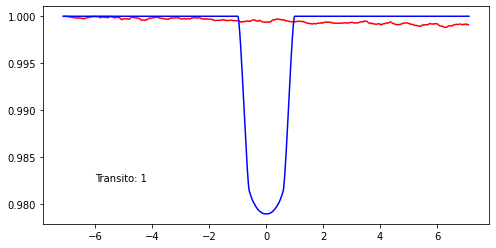

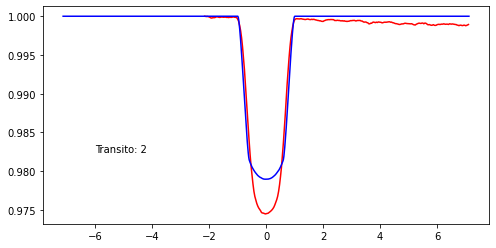

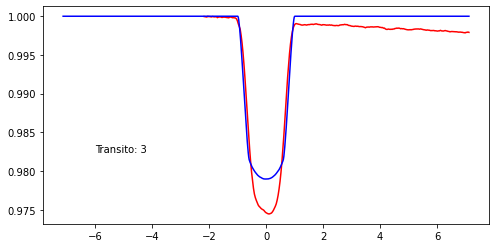

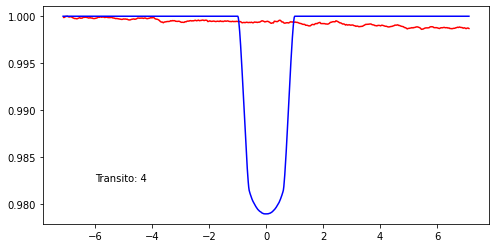

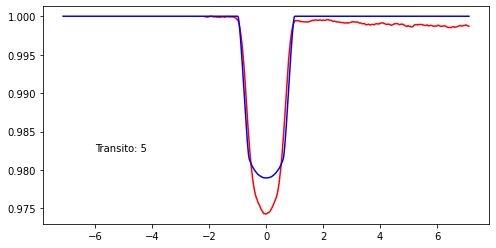

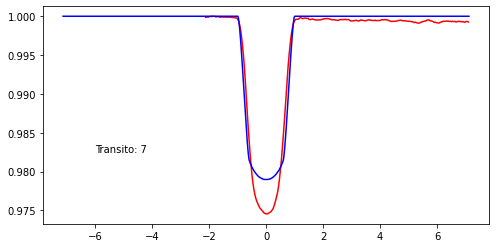

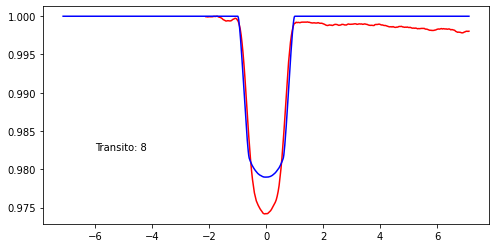

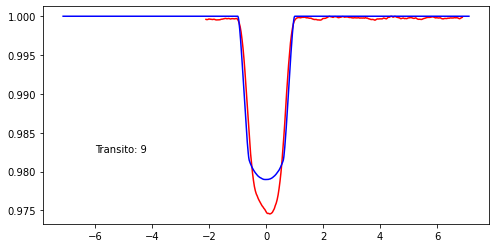

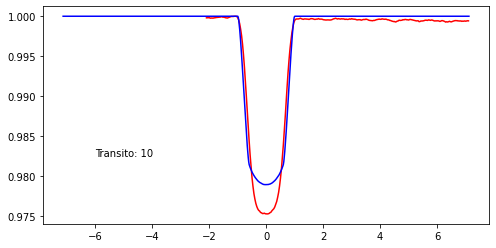

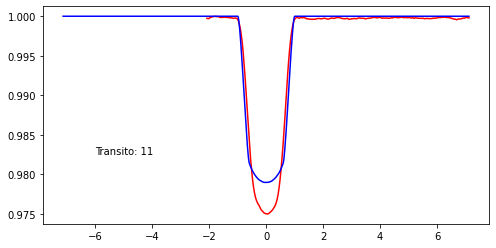

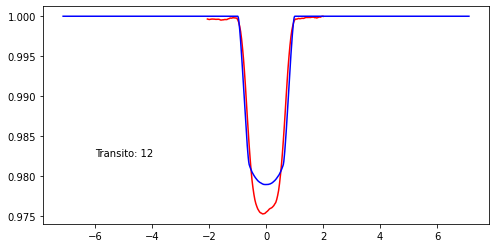

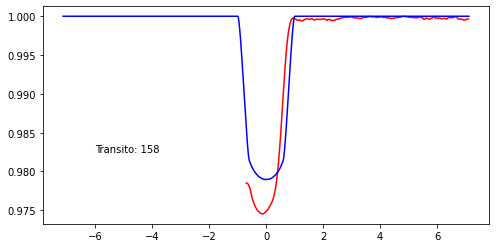

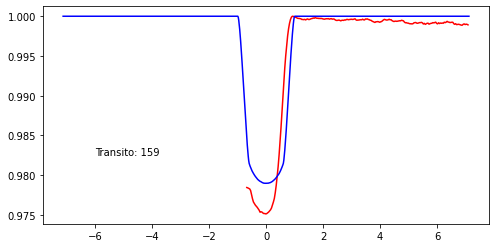

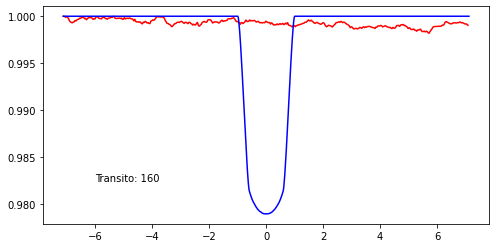

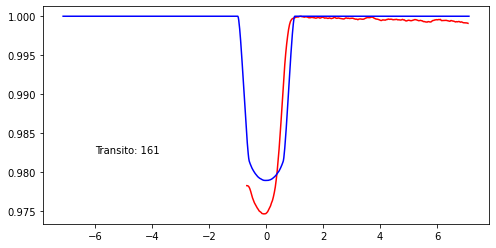

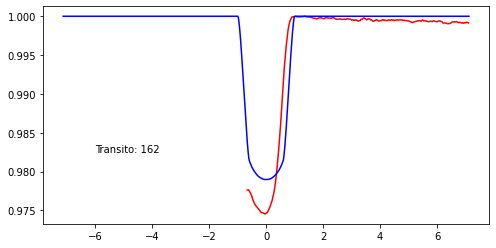

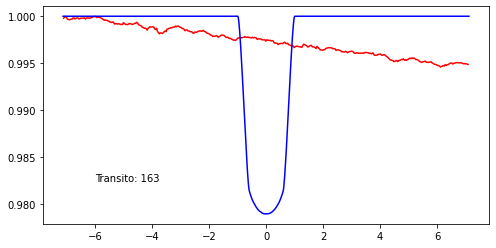

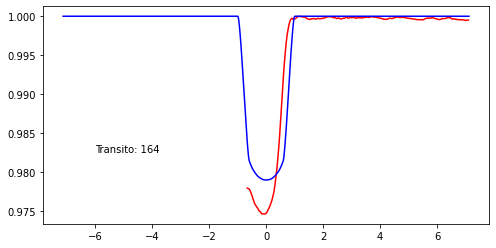

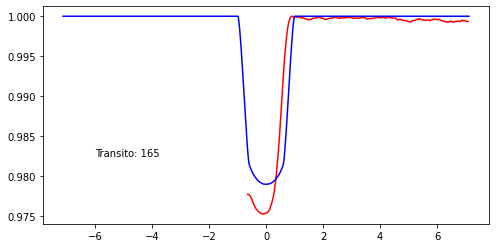

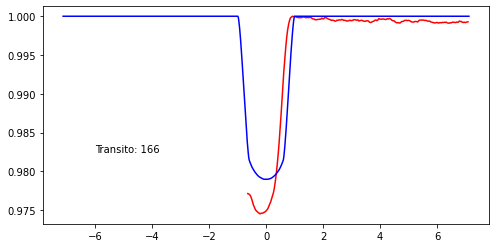

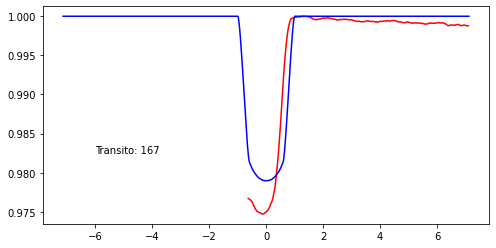

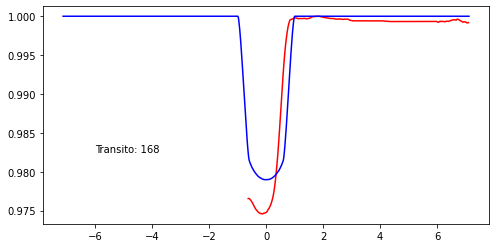

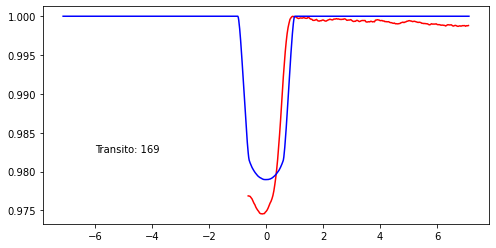

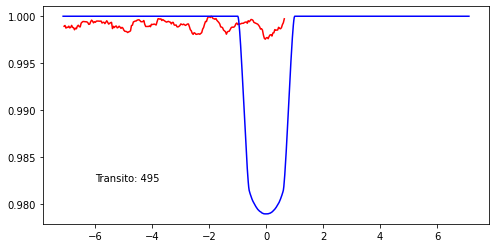

In [7]:
for i in range(int(nt)):
    try:
        selectedTransit = i #transito selecionado
        time_phased, smoothed_LC = tratamento.select_transit_smooth(selectedTransit)

        plt.rcParams['figure.figsize']= 8,4
        graf1,ax = plt.subplots()

        ax.plot(time_phased, smoothed_LC, "r", ms = 2)
        ax.plot(ts_model, ls_model, "b", ms = 2)
        ax.annotate(f"Transito: {i}", (-6, 0.9825))
        
    except:
        pass


### Curvas de luz resultantes 
_Abaixo, temos representadas a curva de luz inicial com a curva de luz obtida atrav√©s dos dados inputados pelo telesc√≥pio (```LightKurve```) ap√≥s o tratamento. √â utilizada a curva de luz inicial para a compara√ß√£o da curva de luz obtida atrav√©s do telesc√≥pio._

In [88]:
print(ts_model[301])
print(time_phased[0])

-2.1166666666666667
-2.1166312093846495


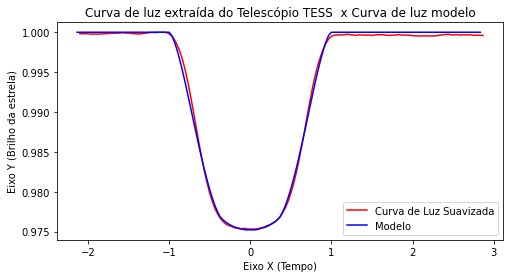

In [218]:
# COM ESCOLHA DE TR√ÇNSITO
selectedTransit = 10 #transito selecionado
time_phased, smoothed_LC = tratamento.select_transit_smooth(selectedTransit)

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(time_phased[0:150], smoothed_LC[0:150], "r", ms=2, label='Curva de Luz Suavizada')
ax.plot(ts_model[300:600][::2], ls_model[300:600][::2], "b", ms=2, label='Modelo')


plotLegendModel(ax, mission)


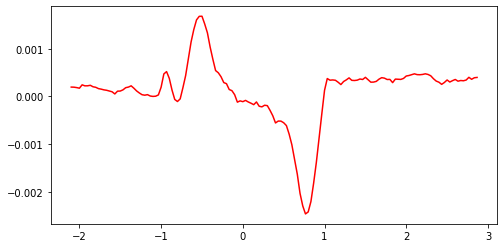

In [219]:
ruidos = ls_model[300:600][::2] - smoothed_LC[0:150]

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(time_phased[0:150], ruidos, "r", ms=2, label='Curva de Luz Suavizada')

# üìù MCMC
_Ajustes realizados para a aplica√ß√£o do algoritmo MCMC. As vari√°veis ```nwalkers```, ```niter``` e ```burnin``` podem ser alteradas conforme o pesquisador achar necess√°rio para a aplica√ß√£o do algoritmo_

In [16]:
nwalkers = 35
niter = 35
burnin = 25

ajuste = Ajuste(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin, rsun=rsun, periodo=periodo)

time = time_phased
flux = smoothed_LC

### Chamada do algoritmo MCMC

In [17]:
sampler, pos, prob, state = ajuste.main()

Running burn-in...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25/25 [02:43<00:00,  6.53s/it]


Running production...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [03:45<00:00,  6.44s/it]


### Valores obtidos p√≥s aplica√ß√£o do algoritmo

In [18]:
# os valores aqui resultados podem ser utilizados no mcmc manchado
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([5.06355057e-01, 1.14378509e-01, 2.80005826e-02, 8.38863661e+01,
       1.33262784e+00])

### Conclus√£o 
_Abaixo teremos a curva de luz obtida pelo sat√©lite comparada com a curva de luz tratada atrav√©s do algoritmo MCMC_

[5.06355057e-01 1.14378509e-01 2.80005826e-02 8.38863661e+01
 1.33262784e+00]
Theta max:  [5.06355057e-01 1.14378509e-01 2.80005826e-02 8.38863661e+01
 1.33262784e+00]


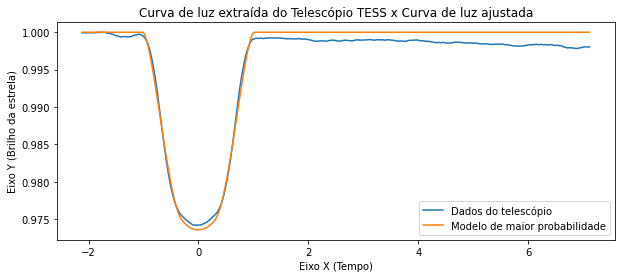

In [19]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajuste.eclipse_mcmc(time, theta_max)

plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()

plt.plot(time, flux, label = 'Dados do telesc√≥pio')
plt.plot(time, best_fit_model, label='Modelo de maior probabilidade')
print('Theta max: ',theta_max)

plotLegendAdjust(plt, mission)

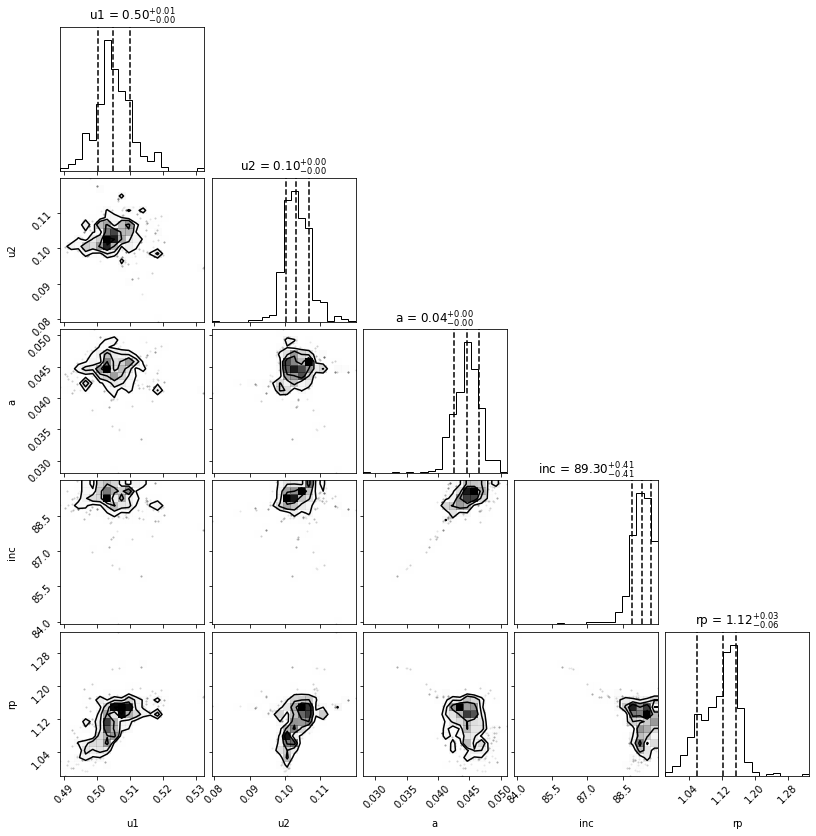

In [20]:
labels = ['u1','u2','a','inc','rp']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [21]:
results = []
for i, label in enumerate(labels):
    q_16, q_50, q_84 = numpy.percentile(samples[:, i], [16, 50, 84])
    print(f"{label}: {q_50:.3f} (+{q_84 - q_50:.3f} / -{q_50 - q_16:.3f})")
    results.append(q_50+(q_84 - q_50))

print(results)

u1: 0.505 (+0.005 / -0.004)
u2: 0.103 (+0.004 / -0.003)
a: 0.045 (+0.002 / -0.002)
inc: 89.303 (+0.411 / -0.410)
rp: 1.124 (+0.031 / -0.063)
[0.5100347077942855, 0.10678029347412264, 0.046515795725497404, 89.71422330260803, 1.154298061365153]


# ‚òÄÔ∏è MCMC Com CME 

* O ::: Origem do Torus 
* b ::: cross-sectional width b (raio das laterais)
* c ::: largura (raio-centro)
* a ::: altura (raio-pico) 

In [13]:
origin = 0. #O
torus_radius = 25 #b
torus_height = 100 #a

In [44]:
results = [0.5051906913165375, 0.10295435368781021, 0.043789879178948804, 89.33768944209946, 1.1462439065377483]
# results = [0.5100347077942855, 0.10678029347412264, 0.046515795725497404, 89.71422330260803, 1.154298061365153]
# results = [0.5100347077942855, 0.10678029347412264, 0.046515795725497404, 89.71422330260803, 1.154298061365153]

In [ ]:
# Par√¢metros resultados no primeiro mcmc 
u1 = results[0]
u2 = results[1]
semi_eixo_UA = results[2]
angulo_inclinacao = results[3]
raio_plan_Jup = results[4]

estrela_ = Estrela(373, rsun, 240., u1, u2, 856)

Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()

planeta_= Planeta(semi_eixo_UA, raio_plan_Jup, periodo, angulo_inclinacao, ecc, anomalia, estrela_.getRaioSun(), mass_planeta)

eclipse = Eclipse(Nx, Ny, raioEstrelaPixel, estrela_, planeta_)
eclipse.setTempoHoras(1.)

In [46]:
estrela_matriz = estrela_.getMatrizEstrela()

temperatura_cme = estrela_.temperaturaEfetiva # temperatura da CME (em K) 4875.0
raio_cme = 50 # em ??
distancia_planeta = 0 #em km d = semi-eixoau*1.5e8
velocidade_cme = 0.1 #tempo = d / v_CME
opacidade = 0.7
p0x = 400
p0y = 220
p1x = 410
p1y = 250
taxa_esfriamento = 10
cme = Estrela.EjecaoMassa(raio_cme, p0x, p0y, p1x, p1y, opacidade, temperatura_cme, velocidade_cme, taxa_esfriamento)

estrela_.addCme(cme)
#estrela_.ejecaoDeMassa(temperatura_cme, raio_cme)

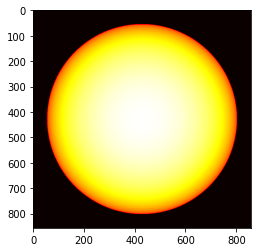

0.3297247886657715


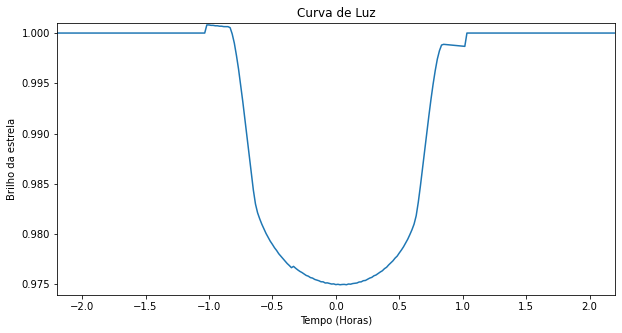

Tempo Total (Tr√¢nsito): 4.397927889585758


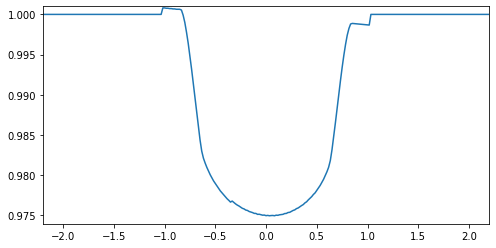

In [47]:
#eclipse
eclipse.setEstrela(estrela_matriz)
estrela_.Plotar(tamanhoMatriz, estrela_matriz)
eclipse.criarEclipse(anim=False, plot=True)

print ("Tempo Total (Tr√¢nsito):", eclipse.getTempoTransito()) 
tempoTransito = eclipse.getTempoTransito()
curvaLuz = eclipse.getCurvaLuz()
tempoHoras = eclipse.getTempoHoras()

#Plotagem da curva de luz 
plt.plot(tempoHoras,curvaLuz)
plt.axis([-tempoTransito/2,tempoTransito/2,min(curvaLuz)-0.001,1.001])                       
plt.show()

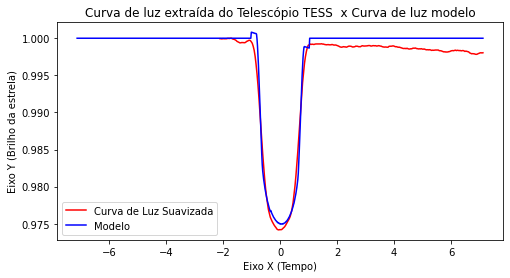

In [55]:
# COM ESCOLHA DE TR√ÇNSITO
selectedTransit = 8 #transito selecionado
time_phased, smoothed_LC = tratamento.select_transit_smooth(selectedTransit)

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()


ax.plot(time_phased, smoothed_LC, "r", ms=2, label='Curva de Luz Suavizada')
ax.plot(ts_model, eclipse.getCurvaLuz(), "b", ms=2, label='Modelo')

plotLegendModel(ax, mission)

In [14]:
nwalkers = 35
niter = 35
burnin = 15
ndim = 1

ajusteCME = AjusteCME(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin, ndim, eclipse,  rsun, periodo)

time = time_phased
flux = smoothed_LC

In [15]:
sampler, pos, prob, state = ajusteCME.main()

Running burn-in...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15/15 [03:53<00:00, 15.60s/it]


Running production...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [08:31<00:00, 14.61s/it]


In [16]:
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([1.07907214e+00, 4.62291110e+02, 2.40185218e+02, 4.86276853e+02,
       2.18916417e+02, 8.61923228e-01, 4.76966520e-01, 1.06494593e+01])

In [17]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajusteCME.eclipse_mcmc(time, theta_max)

[1.07907214e+00 4.62291110e+02 2.40185218e+02 4.86276853e+02
 2.18916417e+02 8.61923228e-01 4.76966520e-01 1.06494593e+01]


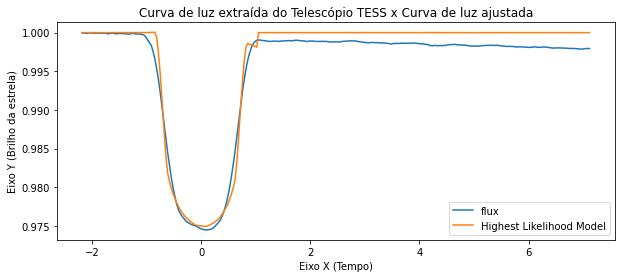

Theta max:  [1.07907214e+00 4.62291110e+02 2.40185218e+02 4.86276853e+02
 2.18916417e+02 8.61923228e-01 4.76966520e-01 1.06494593e+01]


In [18]:
### Plotagem de resultados #### 
plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()
plt.plot(time, flux, label = 'flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plotLegendAdjust(plt, mission)

print('Theta max: ',theta_max)

# üéØ MCMC Manchado
_Ajustes realizados para a aplica√ß√£o do algoritmo MCMC em uma Estrela manchada.

In [ ]:
results = [0.4876834160643441, 0.1082646099893523, 0.04011797773536661, 88.02694810702533, 1.179830450228242]

In [ ]:
# Par√¢metros resultados no primeiro mcmc (Sem manchas)
u1 = results[0]
u2 = results[1]
semi_eixo_UA = results[2]
angulo_inclinacao = results[3]
raio_plan_Jup = results[4]

estrela_ = Estrela(373, rsun, 240., u1, u2, 856)

Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()

planeta_= Planeta(semi_eixo_UA, raio_plan_Jup, periodo, angulo_inclinacao, ecc, anomalia, estrela_.getRaioSun(), mass_planeta)

eclipse = Eclipse(Nx, Ny, raioEstrelaPixel, estrela_, planeta_)
eclipse.setTempoHoras(1.)

In [ ]:
latsugerida = eclipse.calculaLatMancha()
longsugerida = eclipse.calculaLongMancha(semi_eixo_UA, 1.15, latsugerida)

A latitude sugerida para que a mancha influencie na curva de luz da estrela √©: -17.86183566815458
A longitude sugerida para que a mancha influencie na curva de luz da estrela √©: 0.27029496750332876


In [ ]:
raio_mancha = 0.07
intensidade = 0.5 
latitude = latsugerida
longitude = 15

mancha = Estrela.Mancha(intensidade, raio_mancha, latitude, longitude)

0.1037588119506836


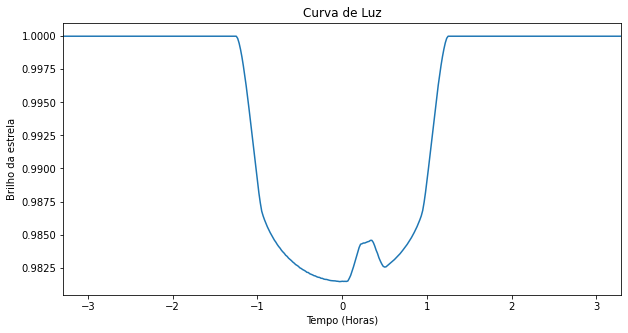

In [ ]:
estrela_.addMancha(mancha)
estrela_.criaEstrelaManchada()

estrela_matriz = estrela_.getMatrizEstrela()
eclipse.setEstrela(estrela_matriz)

eclipse.setTempoHoras(1)
eclipse.criarEclipse(anim = False)

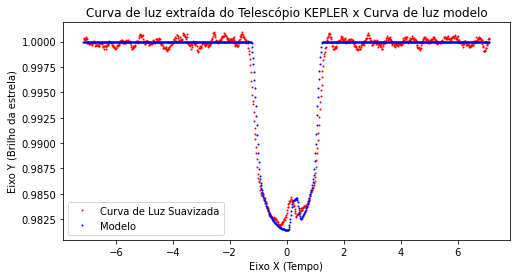

In [ ]:
# COM ESCOLHA DE TR√ÇNSITO
selectedTransit = 2 #transito selecionado
time_phased, smoothed_LC = tratamento.select_transit_smooth(selectedTransit)

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()


ax.plot(time_phased, smoothed_LC, "r.", ms=2, label='Curva de Luz Suavizada')
ax.plot(ts_model, eclipse.getCurvaLuz(), "b.", ms=2, label='Modelo')

plotLegendModel(ax, mission)

### Latitude das manchas 
Para que a mancha estej√° alinhada √† orbita do planeta, √© necess√°ria que a latitude desta esteja dentro da trajet√≥ria da √≥rbita do planeta. Dessa forma, a seguir, sugerimos, com base no angulo de inclina√ß√£o do planeta e seu semi-eixo, a latitude indicada para a plotagem das manchas. 

In [ ]:
nwalkers = 50
niter = 50
burnin = 30
ndim = 1

ajusteManchado = AjusteManchado(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin, ndim, eclipse,  rsun, periodo)

time = time_phased
flux = smoothed_LC

In [ ]:
sampler, pos, prob, state = ajusteManchado.main()

Running burn-in...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30/30 [06:45<00:00, 13.53s/it]


Running production...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [11:25<00:00, 13.71s/it]


In [ ]:
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([  7.1337633 , -17.34553196,   0.09544358,   0.6970613 ])

In [ ]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajusteManchado.eclipse_mcmc(time, theta_max)

[  7.1337633  -17.34553196   0.09544358   0.6970613 ]


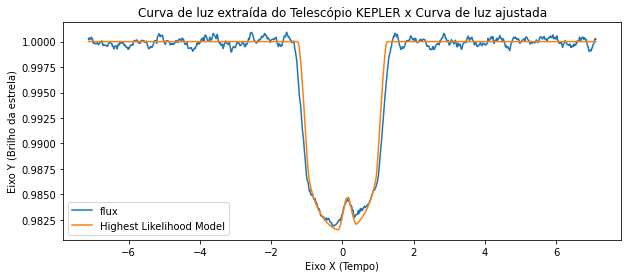

Theta max:  [  7.1337633  -17.34553196   0.09544358   0.6970613 ]


In [ ]:
### Plotagem de resultados #### 
plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()
plt.plot(time, flux, label = 'flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plotLegendAdjust(plt, mission)

print('Theta max: ',theta_max)

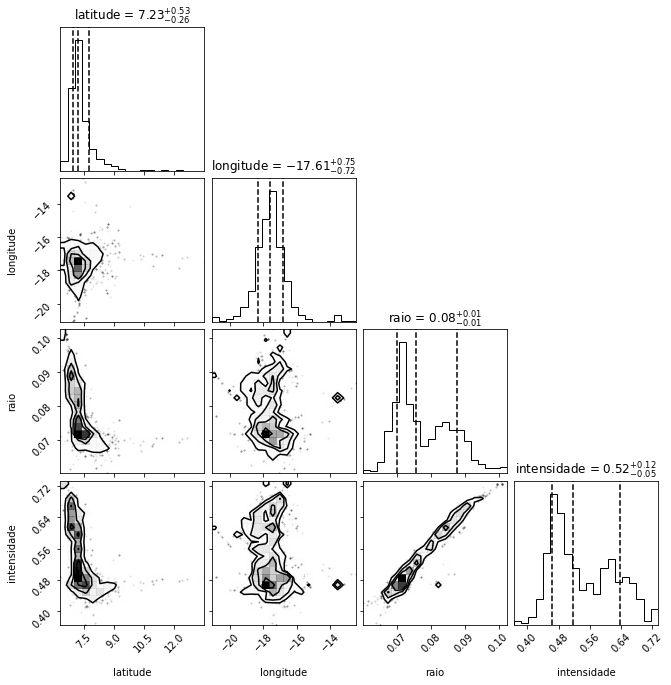

In [ ]:
labels = ['longitude','latitude','raio','intensidade']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])